In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy.interpolate import CubicSpline
import plotly as pty
import time

from fibers import *

from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix
from py_pol.stokes import Stokes
from py_pol.mueller import Mueller
from py_pol.utils import degrees

pi = np.pi
C_c = 299792458.0

# Comparisons to Literature

### "Analysis of polarization mode dispersion of single mode elliptic-core optical fibers"
#### A. Mabrouki, M. Gadonna, A. Gouronnec, R. Goarin, R. Le Naour, *Opt. Comm.* 149, 1998

As a first check, if there's no tension and it's just a long fiber length, what's the PMD like?

In [622]:
# Initialize the fiber

w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.0005494
m0 = 0.036
m1 = 0.000
Tref = 20
rc = 0.25
tf = 0
tr = 0

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})
print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/epsilon**2)))
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

The chosen epsilon corresponds to eccentricity 0.03313.
0.14098 ps total
0.09100 ps/sqrt(km)


So with $\epsilon = 1.0$ and a radius of curvature of 25 cm I get PMD less than that reported in the paper. So I added on a small $\epsilon$ to raise it until I got the right PMD. Now I add on some tension, which *decreases* it (which is correct) until I hit the right PMD value again.

In [623]:
f.tf = 0.00357*9.8
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

0.10228 ps total
0.06602 ps/sqrt(km)


So this is correct. Now with this tension, if I try a smaller radius of curvature...

In [624]:
f.rc = 0.08
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

0.58532 ps total
0.37782 ps/sqrt(km)


It did increase, but the magnitude is wildly wrong. (The same happens at 1550 nm.)

So let me now try random fibers with polarization rotators. They explicitly state that their fibers are low-PMD and this is an important thing, so let's see. I'll try the same procedure as before, namely adding on some rotators at some length, then turning on epsilon until I get the right PMD average, then adding enough tension until I match that number, then seeing what happens when I decrease the curvature radius.

In [671]:
w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.0029
Tref = 20
rc = 0.25
tf = 0
tr = 0
m0 = 0.036
m1 = 0

Lr = 50

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/epsilon**2)))

nExp = 1000
dgds = np.zeros(nExp)
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    dgds[i] = f.calcDGD(dw0=0.0001e-9)*1e12

The chosen epsilon corresponds to eccentricity 0.07599.


E[t] = 0.140 ps
This corresponds to D_PMD = 0.091 ps/sqrt(km).
 


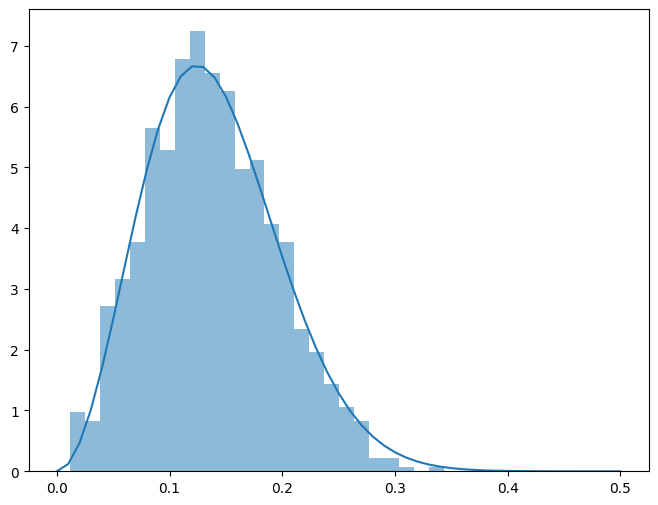

In [672]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds, bins=25)

x2 = np.linspace(0, 0.5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

In [681]:
w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.0029
Tref = 20
rc = 0.25
tf = 0.029*9.8
tr = 0
m0 = 0.036
m1 = 0

Lr = 50

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/epsilon**2)))

nExp = 1000
dgds = np.zeros(nExp)
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    dgds[i] = f.calcDGD(dw0=0.0001e-9)*1e12

The chosen epsilon corresponds to eccentricity 0.07599.


E[t] = 0.100 ps
This corresponds to D_PMD = 0.065 ps/sqrt(km).
 


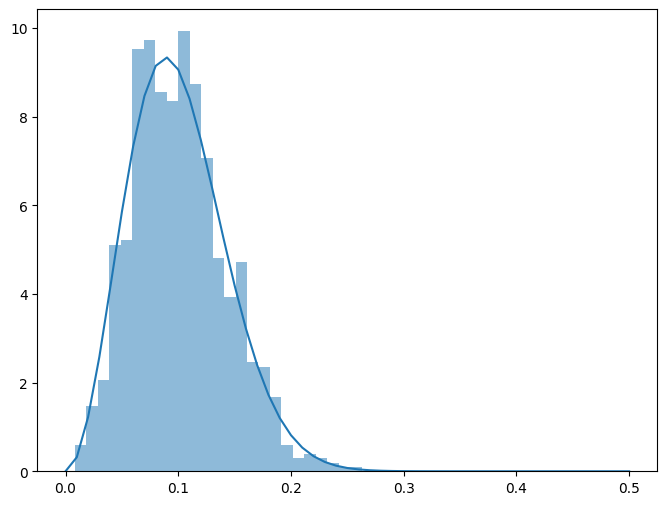

In [682]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds, bins=25)

x2 = np.linspace(0, 0.5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

In [683]:
w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.0029
Tref = 20
rc = 0.08
tf = 0.029*9.8
tr = 0
m0 = 0.036
m1 = 0

Lr = 50

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/epsilon**2)))

nExp = 1000
dgds = np.zeros(nExp)
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    dgds[i] = f.calcDGD(dw0=0.0001e-9)*1e12

The chosen epsilon corresponds to eccentricity 0.07599.


E[t] = 0.075 ps
This corresponds to D_PMD = 0.048 ps/sqrt(km).
 


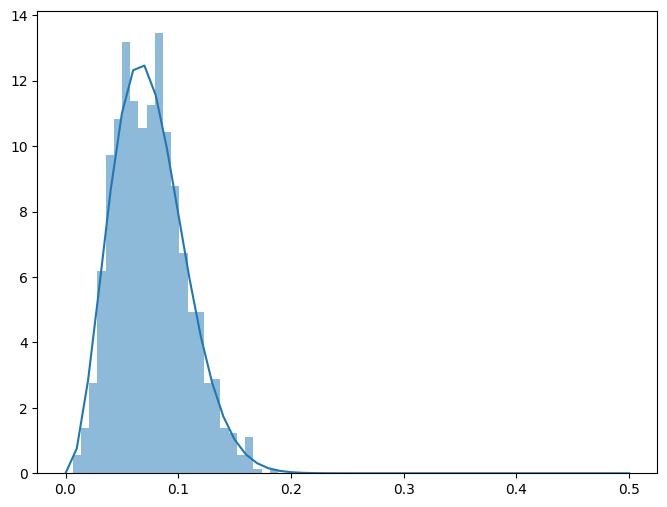

In [684]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds, bins=25)

x2 = np.linspace(0, 0.5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

So this *decreased* rather than increased the PMD.

There's one final set of things I can try, which is comparing the "quasi-circular" fiber to the fiber with a measured eccentricity. Here's the "quasi-circular" fiber in State 5 again:

In [709]:
# Initialize the fiber

w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.0005494
m0 = 0.036
m1 = 0.000
Tref = 20
rc = 0.25
tf = 0
tr = 0

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})
print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/epsilon**2)))
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

The chosen epsilon corresponds to eccentricity 0.03313.
0.14098 ps total
0.09100 ps/sqrt(km)


If $e = 0.22$...

In [712]:
f.L0 = 4.98e3
ecc = 0.22
f.epsilon = np.sqrt(1/(1-ecc**2))
print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/f.epsilon**2)))
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(4.98)))

The chosen epsilon corresponds to eccentricity 0.22000.
19.54559 ps total
8.75859 ps/sqrt(km)


Well, it did go up... but by far too much. If I add on the tension that was previously correct:

In [691]:
f.epsilon = 1.0005494
f.tf = 0.00357*9.8
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

0.10228 ps total
0.06602 ps/sqrt(km)


In [692]:
ecc = 0.22
f.epsilon = np.sqrt(1/(1-ecc**2))
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

9.38086 ps total
6.05532 ps/sqrt(km)


It went down instead of up. And when I change the radius of curvature...

In [693]:
f.rc = 0.08
print("{:.5f} ps total".format(f.calcDGD(dw0=0.0001e-9)*1e12))
print("{:.5f} ps/sqrt(km)".format(f.calcDGD(dw0=0.0001e-9)*1e12/np.sqrt(2.4)))

8.69326 ps total
5.61148 ps/sqrt(km)


It went down, but not by anywhere near as much as the paper.

Just to be thorough, let's do an ensemble thing.

In [713]:
w0 = 1310e-9
T0 = 20
L0 = 2400
r0 = 4.1e-6
r1 = 125e-6/2
ecc = 0.22
epsilon = np.sqrt(1/(1-ecc**2))
Tref = 20
rc = 0.25
tf = 0
tr = 0
m0 = 0.036
m1 = 0

Lr = 50

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

print("The chosen epsilon corresponds to eccentricity {:.5f}.".format(np.sqrt(1-1/f.epsilon**2)))

nExp = 1000
dgds = np.zeros(nExp)
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    dgds[i] = f.calcDGD(dw0=0.0001e-9)*1e12

The chosen epsilon corresponds to eccentricity 0.22000.


E[t] = 1.292 ps
This corresponds to D_PMD = 0.834 ps/sqrt(km).
 


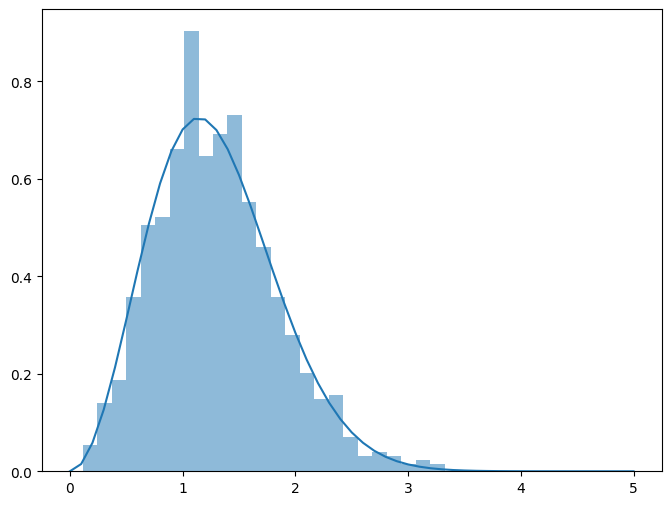

In [717]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds, bins=25)

x2 = np.linspace(0, 5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

Don't think I should even bother trying anything else really.

### "Long-Term Measurement of PMD and Polarization Drift in Installed Fibers"
#### Magnus Karlsson, Jonas Brentel, and Peter A. Andrekson, *JLT* 18(7), 2000

Here they look at a 127-km fiber's DGD with time and temperature change. The fiber is dispersion-shifted to have its dispersion zero at about 1548 nm. I am interested in whether the temperature-vs-DGD dependence can be reproduced qualitatively.

In [8]:
Ltot = 127e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 13

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 150

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

nExp = 1000
dgds1 = np.zeros(nExp)
dgds2 = np.zeros(nExp)
t0 = time.time()
for i in range(nExp):
    f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    f.hingeDict['T0'] = T0
    dgds1[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    f.hingeDict['T0'] = T1
    dgds2[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
Completed in 22.11 minutes.


E[t] = 2.757 ps
This corresponds to D_PMD = 0.245 ps/sqrt(km).
 


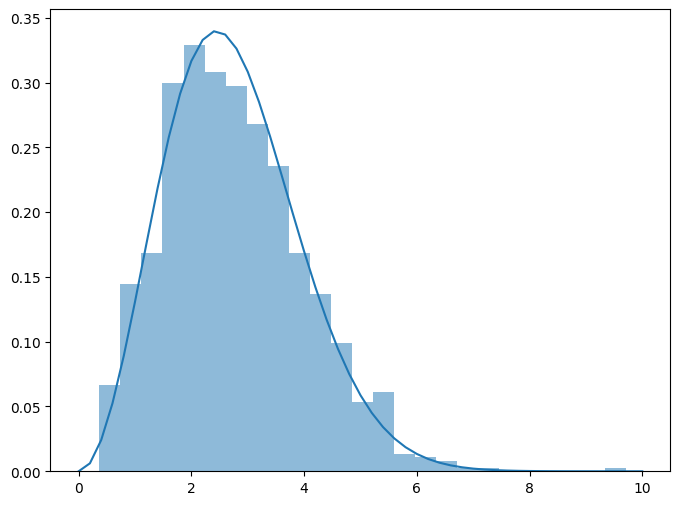

In [9]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds1, bins=25)

x2 = np.linspace(0, 10, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

E[t] = 2.776 ps
This corresponds to D_PMD = 0.246 ps/sqrt(km).
 


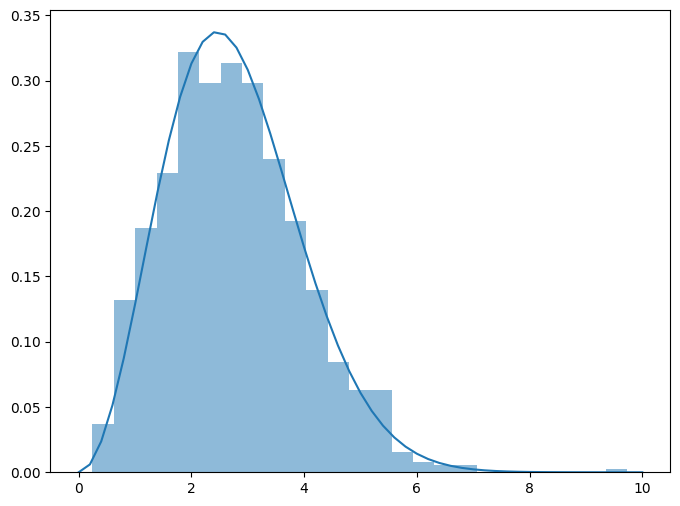

In [10]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds2, bins=25)

x2 = np.linspace(0, 10, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

[1.58745927e+02 5.83100871e-03 7.46683771e-01]


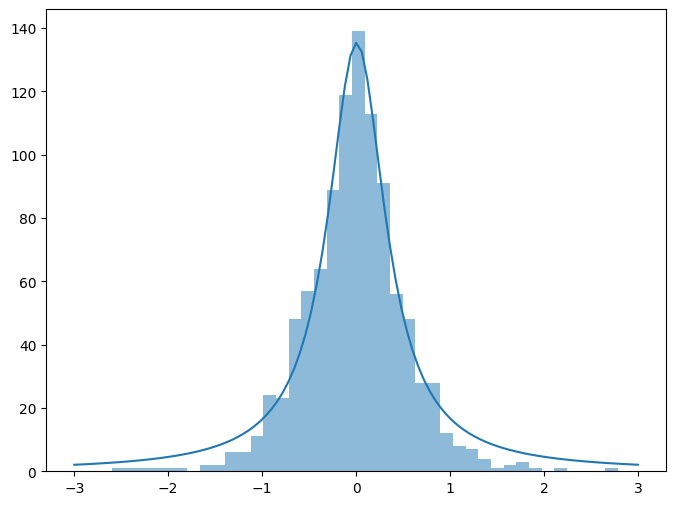

In [12]:
#def MB(x, a, o, sigma): return a*np.exp(-((x-o)**2)/(2*(sigma**2)))
def MB(x, a, o, sigma): return (a/pi)*(sigma/2)/((x-o)**2 + (sigma/2)**2)

ns, bins = np.histogram(dgds2-dgds1, bins=40)

x2 = np.linspace(-3, 3, 101)
xs = (bins[1:] + bins[:-1])/2
ys = ns

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([150, 0, 5]))
print(popt)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, *popt))
plt.show()

In [18]:
Ltot = 127e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 13

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 150

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

f1 = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
f2 = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})

w0s = np.linspace(1505, 1565, nw0s)*1e-9
dgds1 = np.zeros(len(w0s))
dgds2 = np.zeros(len(w0s))
t0 = time.time()
for i in range(len(w0s)):
    f1.w0 = w0s[i]
    dgds1[i] = f1.calcDGD(dw0=0.0001e-9)*1e12
    f2.w0 = w0s[i]
    dgds2[i] = f2.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600  
Completed in 15.06 minutes.


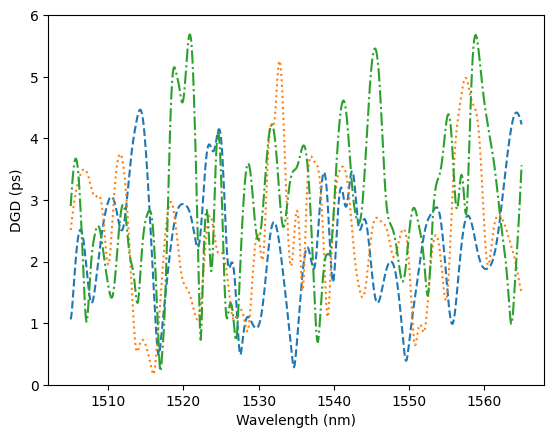

In [24]:
fig, ax = plt.subplots()
ax.plot(w0s*1e9, dgds1, linestyle='dashed')
ax.plot(w0s*1e9, dgds2, linestyle='dotted')
ax.plot(w0s*1e9, dgds, ls='-.')
ax.set_ylabel("DGD (ps)")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylim(0,6)
plt.show()

### "Analysis of polarization mode dispersion fluctuations in single mode fibres due to temperature"
#### Nassima Boudrioua, Azzedine Boudrioua, Fabrice Monteiro, Etienne Losson, Abas Dandache, and Régis Kremer, *Opt. Comm.* 281, 2008

Note that this paper gives a citation for its material properties which is Poh-Boon Phua's thesis, where he doesn't talk at all about simulating fibers in this way or give any such material constants.

In [315]:
# Initialize the fiber

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = np.sqrt(1/(1-ecc**2))
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

In [316]:
print(f.alpha0)
print(f.alpha1)
print(f.nu_p)
print(f.p11)
print(f.p12)
print(f.B_ATS)

8.854792000000001e-07
5.4e-07
0.17153384000000002
0.12132868000000001
0.27065736
1.4060485620030325


Let's try to reproduce Fig 2...

In [269]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197, 0.275, 0.332, 0.378, 0.417])
T0sarr = np.linspace(0, 150, 151)
Bs = np.zeros((5,151))
for j in range(len(eccs)):
    f.epsilon = e2(eccs[j])
    for i in range(len(T0sarr)):
        f.T0 = T0sarr[i]
        Bs[j][i] = f.B_ATS

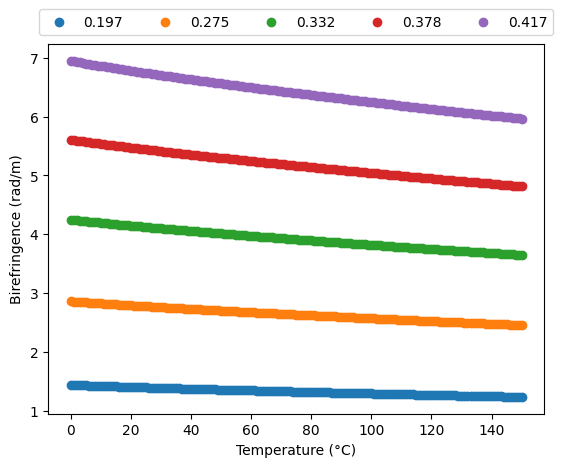

In [295]:
fig, ax = plt.subplots()
for j in range(len(eccs)):
    ax.scatter(T0sarr, Bs[j], label=str(eccs[j]))
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Birefringence (rad/m)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

Can the material constants $(\alpha_1 - \alpha_0)(p_{11} - p_{12})/(1-\nu_p^2)$ explain the factor of two difference?

In [277]:
(8.855e-7 - 5.4e-7)*(0.121 - 0.271)/(1 - 0.171**2)

-5.338606183409065e-08

In [278]:
(9.09e-7 - 5.6e-7)*(0.126 - 0.260)/(1 - 0.166**2)

-4.8091201138574555e-08

So the material constants alone aren't adequate to explain the factor of 2 difference I see. The other possibility is that the refractive index change with temperature is very different...

In [279]:
_SellmeierCoeffs = {'SiO2': np.array(
                            [[[1.10127, -4.94251e-5, 5.27414e-7, -1.59700e-9, 1.75949e-12],
                              [-8.906e-2, 9.0873e-6, -6.53638e-8, 7.77072e-11, 6.84605e-14]],
                             [[1.78752e-5, 4.76391e-5, -4.49019e-7, 1.44546e-9, -1.57223e-12],
                              [2.97562e-1, -8.59578e-4, 6.59069e-6, -1.09482e-8, 7.85145e-13]],
                             [[7.93552e-1, -1.27815e-3, 1.84595e-5, -9.20275e-8, 1.48829e-10],
                              [9.34454, -70.9788e-3, 1.01968e-4, -5.07660e-7, 8.21348e-10]]]
                            ),
                    'GeO2': np.array(
                            [[0.80686642, 0.068972606],
                             [0.71815848, 0.15396605],
                             [0.85416831, 11.841931]]
                            ),
                    'F': np.array(
                         [[[-61.25, 0.2565],
                           [-23.0,0.101]],
                          [[73.9,-1.836],
                           [10.7,-0.005]],
                          [[233.5,-5.82],
                           [1090.5,-24.695]]]
                         )
                   }

# Methods for calculating material properties of silica-germania binary glasses
# -------------------------------------------------------------------------------------------------------------------------------------
def _calcN_Ge(w0, T0):
    """ Get the refractive index of germania at a given temperature and wavelength. """
    # We have Sellmeier coefficients and a formula for the thermo-optic coefficient
    # So we'll just add the two together
    wc = w0*1e6; Tc = T0 + 273.15 # Unit conversions
    n0 = np.sqrt(1 + np.sum(np.array([_SellmeierCoeffs['GeO2'][i][0]*wc**2/(wc**2 - _SellmeierCoeffs['GeO2'][i][1]**2) for i in range(len(_SellmeierCoeffs['GeO2']))])))
    Delta_n0 = 6.2153e-13/4*(Tc**4 - (24+273.15)**4) - 5.3387e-10/3*(Tc**3 - (24+273.15)**3) + 1.6654e-7/2*(Tc**2 - (24+273.15)**2)
    return n0 + Delta_n0
def _calcNs(w0, T0, m0, m1):
    """
    Calculates the refractive indices for the core and cladding silica-based material at
    wavelength w0 (m) and temperature T0 (°C). The molar fractions are m0 for the core and
    m1 for the cladding. If m is negative, dope the silica with fluorine; if positive,
    dope it with germania.
    Returns: n0 (refractive index of core), n1 (refractive index of cladding)
    """
    wc = w0*1e6; Tc = T0 + 273.15 # Unit conversions
    Tpows = np.array([Tc**i for i in [0,1,2,3,4]])
    nGe = _calcN_Ge(w0, T0)
    sc0 = np.zeros((3,2))
    sc1 = np.zeros((3,2))
    for i in range(3):
        for j in range(2):
            sc0[i][j] = np.dot(_SellmeierCoeffs['SiO2'][i][j], Tpows)
            sc1[i][j] = sc0[i][j] + (m1 < 0)*(_SellmeierCoeffs['F'][i][j][0]*np.abs(m1)**2 + _SellmeierCoeffs['F'][i][j][1]*np.abs(m1))
            sc0[i][j] = sc0[i][j] + (m0 < 0)*(_SellmeierCoeffs['F'][i][j][0]*np.abs(m0)**2 + _SellmeierCoeffs['F'][i][j][1]*np.abs(m0))
    n0 = np.sqrt(1 + np.sum(np.array([sc0[i][0]*wc**2/(wc**2 - sc0[i][1]**2) for i in range(len(sc0))])))
    n1 = np.sqrt(1 + np.sum(np.array([sc1[i][0]*wc**2/(wc**2 - sc1[i][1]**2) for i in range(len(sc1))])))
    if (m0 > 0):
        n0 = (1-m0)*n0 + m0*nGe
    if (m1 > 0):
        n1 = (1-m1)*n1 + m1*nGe
    return n0, n1

In [281]:
# From the paper

def nR(w0): return np.sqrt(1.3107237 + 0.7935797*w0**2/(w0**2 - 1.0959659e-2) + 0.9237144*w0**2/(w0**2 - 100))

Actually reading more carefully, the Boudrioua paper doesn't do a very good job of specifying what everything is, specifically how it calculates the thermo-optic coefficients. So I'm not really sure how to compare the two sets of refractive indices. Let's just do a few more comparisons, just keeping that factor of 2 in mind I guess.

Let's try Figs 3-4 now...

In [307]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.1197, 0.197, 0.275, 0.332, 0.378, 0.417])
T0s = np.array([-10.0, 45.0, 100.0])
Vsarr = np.linspace(1.0, 2.4, 71)
Bs = np.zeros((6,3,71))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for j in range(len(T0s)):
        f.T0 = T0s[j]
        f.w0 = 1550e-9
        c0 = f.v*f.w0
        for k in range(len(Vsarr)):
            f.w0 = c0/Vsarr[k]
            Bs[i][j][k] = f.B_ATS

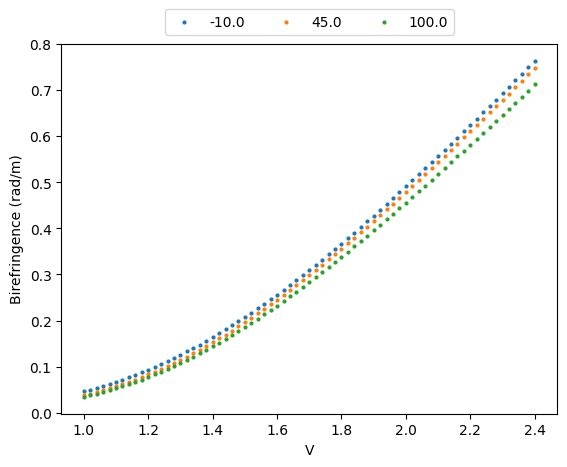

In [308]:
fig, ax = plt.subplots()
for j in range(len(T0s)):
    ax.scatter(Vsarr, Bs[0][j], label=str(T0s[j]), s=4)
ax.set_xlabel("V")
ax.set_ylabel("Birefringence (rad/m)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

In [311]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.1197, 0.197, 0.275, 0.332, 0.378, 0.417])
T0s = np.array([25.0, 100.0, 200.0])
Vsarr = np.linspace(1.0, 2.4, 71)
Bs = np.zeros((6,3,71))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for j in range(len(T0s)):
        f.T0 = T0s[j]
        f.w0 = 1550e-9
        c0 = f.v*f.w0
        for k in range(len(Vsarr)):
            f.w0 = c0/Vsarr[k]
            Bs[i][j][k] = f.B_ATS

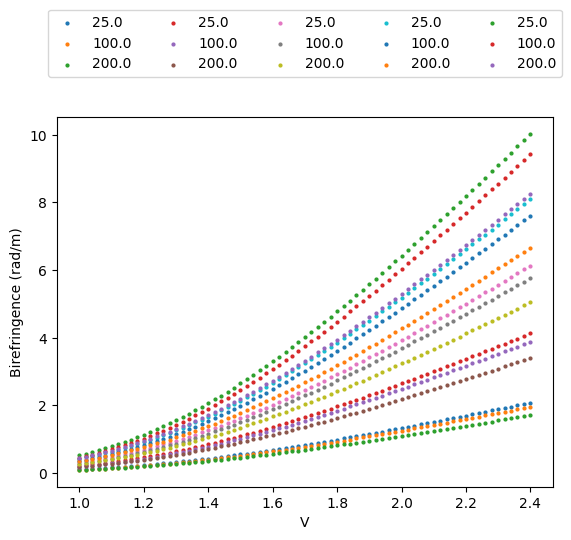

In [312]:
fig, ax = plt.subplots()
for i in range(1,5+1):
    for j in range(len(T0s)):
        ax.scatter(Vsarr, Bs[i][j], label=str(T0s[j]), s=4)
ax.set_xlabel("V")
ax.set_ylabel("Birefringence (rad/m)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol = 5)
plt.show()

Freakishly, Figs 3 and 4 predict about *half* of what I predict.

As best I can tell, Figs 2 and 4 of this paper are inconsistent with each other. Multiple points on the plots of Fig 2 should correspond to multiple points on the plots of Fig 4 (with $V \approx 2.0$) and they seem to be off by a factor of 4.

Let's get Fig 5 just for fun.

Blarg, it turns out that varying by $V$ is nontrivial because it's not just $c/\lambda$, but $c$ is a function of $\lambda$ because it's a function of $n_{1,2}$ also. So we'll take the strategy of numerically solving by taking a sample fiber length and computing $V$ as I vary $\lambda$.

In [357]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 25           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

w0n = 100
w0s = np.linspace(1300, 3400, w0n+1)*1e-9
Vs = np.zeros(w0n+1)
for i in range(w0n+1):
    f.w0 = w0s[i]
    Vs[i] = f.v

In [358]:
Vs

array([2.42978148, 2.39088178, 2.35323465, 2.31678044, 2.28146328,
       2.24723074, 2.2140336 , 2.18182558, 2.15056317, 2.12020536,
       2.0907135 , 2.06205113, 2.03418383, 2.00707907, 1.98070605,
       1.95503567, 1.93004032, 1.90569386, 1.88197145, 1.85884956,
       1.83630579, 1.81431889, 1.7928686 , 1.77193568, 1.75150178,
       1.73154941, 1.71206192, 1.6930234 , 1.67441867, 1.65623324,
       1.63845324, 1.62106543, 1.60405715, 1.58741625, 1.57113114,
       1.55519068, 1.53958422, 1.52430153, 1.5093328 , 1.49466863,
       1.48029999, 1.46621818, 1.45241488, 1.43888207, 1.42561204,
       1.41259737, 1.39983094, 1.38730587, 1.37501555, 1.36295361,
       1.35111389, 1.33949049, 1.3280777 , 1.31686999, 1.30586207,
       1.2950488 , 1.28442523, 1.27398656, 1.26372819, 1.25364564,
       1.2437346 , 1.23399089, 1.22441046, 1.21498942, 1.20572398,
       1.19661048, 1.18764538, 1.17882524, 1.17014674, 1.16160665,
       1.15320186, 1.14492934, 1.13678615, 1.12876945, 1.12087

In [359]:
vFunc = CubicSpline(w0s, Vs)

In [369]:
Ltot = 80e3       # Total length of fiber

w0 = 1550e-9      # Operating wavelength
T0 = 25           # Operating temperature
m0 = 0.03652       # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

N0 = 800           # Number of hinges

segmentDict = {'epsilon': 1.005, 'm0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': 20, 'dist': 'normal'}}
hingeDict = {}

f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False)

eccs = np.array([0.197])
T0s = np.array([25.0, 100.0, 200.0])
Vsarr = np.linspace(1.0, 2.4, 81)
DGDs = np.zeros((len(eccs),len(T0s),len(Vsarr)))
for i in range(len(eccs)):
    f.segmentDict['epsilon'] = e2(eccs[i])
    for j in range(len(T0s)):
        f.segmentDict['T0'] = T0s[j]
        for k in range(len(Vsarr)):
            f.w0 = opt.fsolve(lambda x: vFunc(x) - Vsarr[k], np.array([2000e-9]))[0]
            DGDs[i][j][k] = f.calcDGD()*1e12

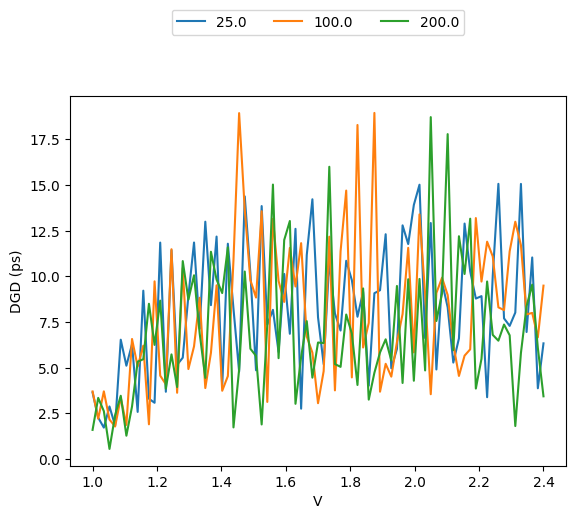

In [370]:
fig, ax = plt.subplots()
for i in range(len(eccs)):
    for j in range(len(T0s)):
        ax.plot(Vsarr, DGDs[i][j], label=str(T0s[j]))
ax.set_xlabel("V")
ax.set_ylabel("DGD (ps)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol = 5)
plt.show()

Ooooookay, let's try averaging. 

In [379]:
Ltot = 80e3       # Total length of fiber

w0 = 1550e-9      # Operating wavelength
T0 = 25           # Operating temperature
m0 = 0.03652       # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

N0 = 800           # Number of hinges

segmentDict = {'epsilon': e2(0.197), 'm0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': 20, 'dist': 'normal'}}
hingeDict = {}

nExp = 100
Vsarr = np.array([1.0, 1.7, 2.4])
#Vsarr = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
dgds = np.zeros((len(Vsarr),nExp))
t0 = time.time()
for j in range(len(Vsarr)):
    w0j = opt.fsolve(lambda x: vFunc(x) - Vsarr[j], np.array([2000e-9]))[0]
    print("{:.2f} nm".format(w0j*1e9))
    for i in range(nExp):
        f = Fiber.random(w0j, Ltot, N0, segmentDict, hingeDict, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False)
        dgds[j][i] = f.calcDGD()*1e12
        if ((i+1) % 10 == 0):
            print(i+1, end= " ")
    print(" ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

3222.42 nm
10 20 30 40 50 60 70 80 90 100  
1859.25 nm
10 20 30 40 50 60 70 80 90 100  
1316.02 nm
10 20 30 40 50 60 70 80 90 100  
 
Completed in 3.22 minutes.


E[t] = 1.813 ps
This corresponds to D_PMD = 0.203 ps/sqrt(km).
 


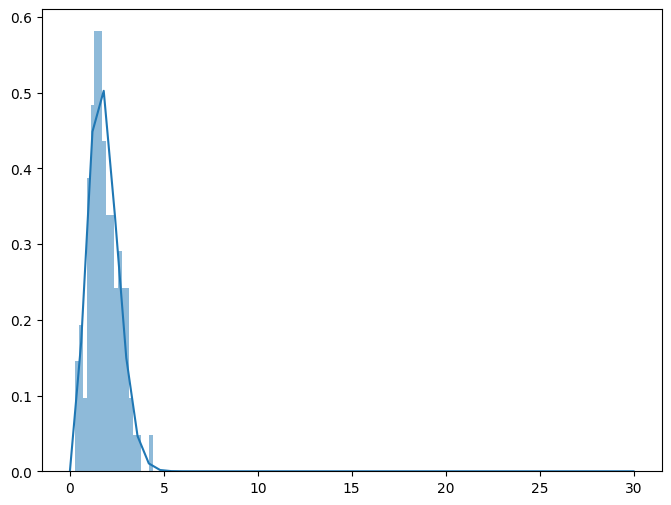

In [382]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds[0], bins=20)

x2 = np.linspace(0, 30, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

In [383]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197])
T0s = np.array([25.0, 100.0, 200.0])
Vsarr = np.linspace(1.0, 2.4, 71)
DGDs = np.zeros((len(eccs),len(T0s),len(Vsarr)))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for j in range(len(T0s)):
        f.T0 = T0s[j]
        for k in range(len(Vsarr)):
            f.w0 = opt.fsolve(lambda x: vFunc(x) - Vsarr[k], np.array([2000e-9]))[0]
            DGDs[i][j][k] = f.calcDGD()*1e12

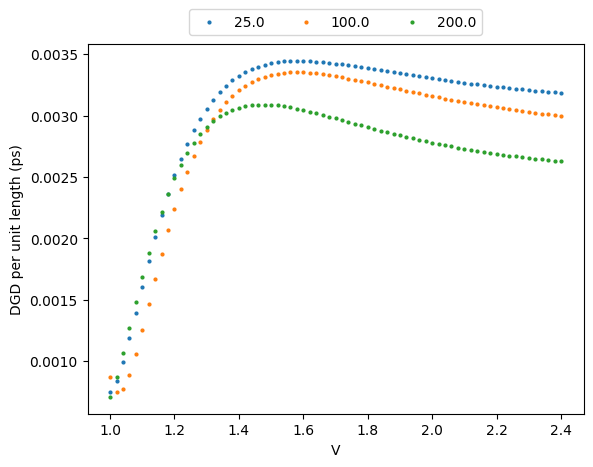

In [385]:
fig, ax = plt.subplots()
for j in range(len(T0s)):
    ax.scatter(Vsarr, DGDs[0][j], label=str(T0s[j]), s=4)
ax.set_xlabel("V")
ax.set_ylabel("DGD per unit length (ps)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

In [386]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197, 0.275, 0.332])
T0s = np.linspace(0, 200, 101)
DGDs = np.zeros((len(eccs),len(T0s)))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for j in range(len(T0s)):
        f.T0 = T0s[j]
        DGDs[i][j] = f.calcDGD()*1e12

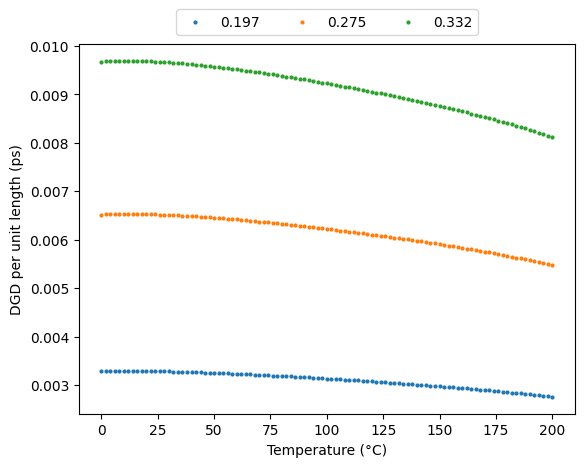

In [387]:
fig, ax = plt.subplots()
for i in range(len(eccs)):
    ax.scatter(T0s, DGDs[i], label=str(eccs[i]), s=4)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("DGD per unit length (ps)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

### "Polarization mode dispersion in single mode optical fibers due to core-ellipticity"
#### Deepak Gupta, Arun Kumar, K. Thyagarajan, *Opt. Comm.* 263, 2006

This paper actually does a somewhat better job of specifying everything that they use in their simulations... so I can tell that I use different numbers for the Poisson's ratios of both silica and germania as well as slightly different CTEs, but this one doesn't do any temperature variation.

As before, I need $V$ as a function of $\lambda$, so here's that...

In [388]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

w0n = 100
w0s = np.linspace(1300, 3400, w0n+1)*1e-9
Vs = np.zeros(w0n+1)
for i in range(w0n+1):
    f.w0 = w0s[i]
    Vs[i] = f.v

vFunc = CubicSpline(w0s, Vs)

We start with Fig 2.

In [389]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197, 0.275, 0.332, 0.378, 0.417])
Vsarr = np.linspace(1.0, 2.4, 71)
BCNCs = np.zeros((len(eccs),len(Vsarr)))
BATSs = np.zeros((len(eccs),len(Vsarr)))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for k in range(len(Vsarr)):
        f.w0 = opt.fsolve(lambda x: vFunc(x) - Vsarr[k], np.array([2000e-9]))[0]
        BCNCs[i][k] = f.B_CNC
        BATSs[i][k] = f.B_ATS

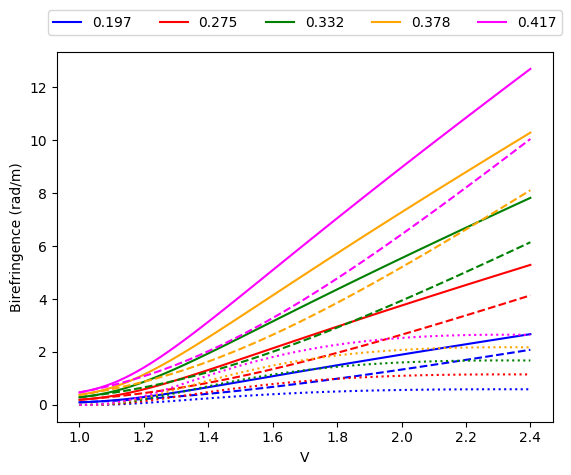

In [414]:
cols = ['blue', 'red', 'green', 'orange', 'magenta']
fig, ax = plt.subplots()
for j in range(len(eccs)):
    ax.plot(Vsarr, BCNCs[j], ls=':', c=cols[j])
    ax.plot(Vsarr, BATSs[j], ls='--', c=cols[j])
    ax.plot(Vsarr, BCNCs[j] + BATSs[j], label=str(eccs[j]), ls='-', c=cols[j])
ax.set_xlabel("V")
ax.set_ylabel("Birefringence (rad/m)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.08), ncol = 5)
plt.show()

In [411]:
print((9.19e-7 - 5.6e-7)*(0.126 - 0.260)/(1 - 0.166**2))
print((8.855e-7 - 5.4e-7)*(0.121 - 0.271)/(1 - 0.172**2))

-4.9469172517903346e-08
-5.340493149329772e-08


The magnitude seems off by a factor of something like 17/13 or about 30%, which is more than I can explain with just material constants. But the curves themselves seem just about spot on.

In [424]:
def e2(ecc): return np.sqrt(1/(1-ecc**2))

w0 = 1550e-9      # Operating wavelength
T0 = 20           # Operating temperature
L0 = 1           # Length of fiber
r0 = 4.1e-6       # Radius of core
r1 = 125e-6/2     # Radius of cladding
ecc = 0.197
epsilon = e2(ecc)
m0 = 0.03652      # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 20         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

f = FiberLength(w0, T0, L0, r0, r1, epsilon, m0, m1, Tref, rc, tf, tr, mProps = {})

eccs = np.array([0.197, 0.275, 0.332, 0.378, 0.417])
Vsarr = np.linspace(1.0, 2.4, 71)
DGDs = np.zeros((len(eccs),len(Vsarr)))
for i in range(len(eccs)):
    f.epsilon = e2(eccs[i])
    for k in range(len(Vsarr)):
        f.w0 = opt.fsolve(lambda x: vFunc(x) - Vsarr[k], np.array([2000e-9]))[0]
        DGDs[i][k] = f.calcDGD()*1e12

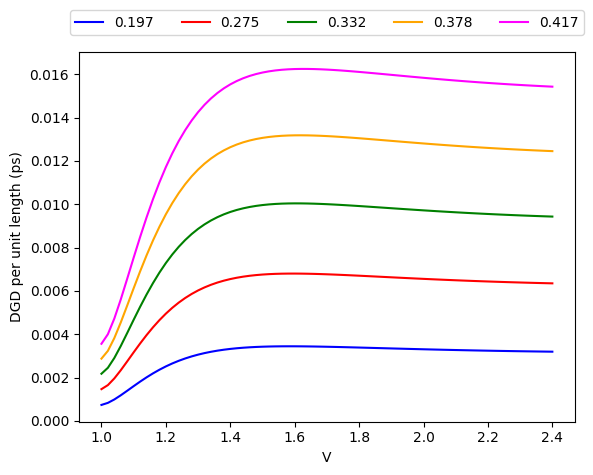

In [425]:
cols = ['blue', 'red', 'green', 'orange', 'magenta']
fig, ax = plt.subplots()
for j in range(len(eccs)):
    ax.plot(Vsarr, DGDs[j], c=cols[j], label=str(eccs[j]))
ax.set_xlabel("V")
ax.set_ylabel("DGD per unit length (ps)")
#ax.set_xlim(0,200)
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.08), ncol = 5)
plt.show()

Now let's try Fig 4.

In [452]:
Ltot = 80e3       # Total length of fiber

w0 = opt.fsolve(lambda x: vFunc(x) - 1.8, np.array([2000e-9]))[0]
T0 = 25           # Operating temperature
m0 = 0.03652       # Doping concentration in core
m1 = 0.000        # Doping concentration in cladding
Tref = 25         # Reference temperature
rc = 0            # Bend radius of curvature
tf = 0            # Axial tension
tr = 0            # Twist rate

N0 = 800           # Number of hinges

segmentDict = {'epsilon': e2(0.197), 'm0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': 10, 'dist': 'normal'}}
hingeDict = {}

nExp = 1000
eccs = np.array([0.24, 0.275, 0.332, 0.398])
dgds = np.zeros((len(eccs),nExp))
t0 = time.time()
for j in range(len(eccs)):
    segmentDict['epsilon'] = e2(eccs[j])
    print(eccs[j])
    for i in range(nExp):
        f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False)
        dgds[j][i] = f.calcDGD(dw0=0.0001e-9)*1e12
        if ((i+1) % 10 == 0):
            print(i+1, end= " ")
    print(" ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0.24
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
0.275
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
0.332
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 

E[t] = 13.073 ps
This corresponds to D_PMD = 1.462 ps/sqrt(km).
 
E[t] = 17.655 ps
This corresponds to D_PMD = 1.974 ps/sqrt(km).
 
E[t] = 25.963 ps
This corresponds to D_PMD = 2.903 ps/sqrt(km).
 
E[t] = 38.423 ps
This corresponds to D_PMD = 4.296 ps/sqrt(km).
 


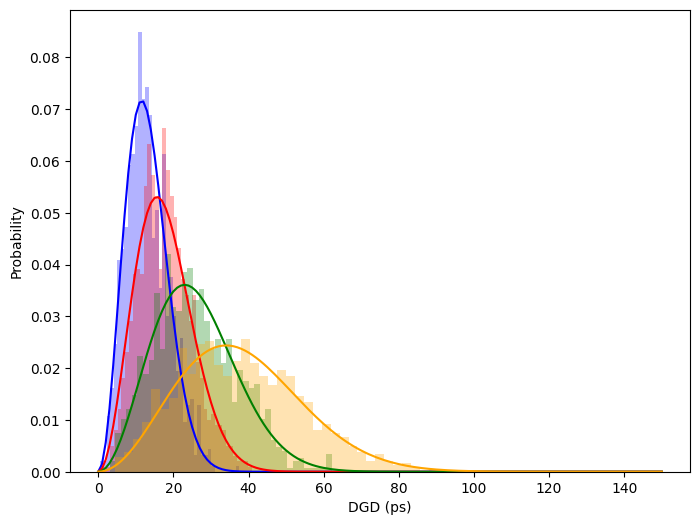

In [457]:
cols = ['blue', 'red', 'green', 'orange']

def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(eccs)):
    ns, bins = np.histogram(dgds[i], bins=40)
    x2 = np.linspace(0, 150, 151)
    xs = (bins[1:] + bins[:-1])/2
    ys = ns/np.sum(ns * (bins[1]-bins[0]))
    popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
    print("E[t] = {:.3f} ps".format(popt[0]))
    print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
    print(" ")
    ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, color=cols[i], alpha=0.3)
    ax.plot(x2, MB(x2, popt[0]), c=cols[i])

ax.set_xlabel("DGD (ps)")
ax.set_ylabel("Probability")
plt.show()

Nailed it honestly.

### "Time Evolution of Polarization Mode Dispersion in Optical Fibers"
#### John Cameron, Liang Chen, Xiaoyi Bao, and John Stears, *IEEE Photonics Technology Letters* 10(9), 1998

First up we have a 36-km spooled fiber:

In [741]:
w0 = 1550e-9
T0 = 20
T1 = 25
L0 = 36e3
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
Tref = 20
rc = 0.15
tf = 0
tr = 0
m0 = 0.036
m1 = 0

Lr = 5

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

nExp = 250
dgds1 = np.zeros(nExp)
dgds2 = np.zeros(nExp)
t0 = time.time()
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    f.segmentDict['T0'] = T0
    dgds1[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    f.segmentDict['T0'] = T1
    dgds2[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250  
Completed in 46.54 minutes.


E[t] = 0.285 ps
This corresponds to D_PMD = 0.048 ps/sqrt(km).
 


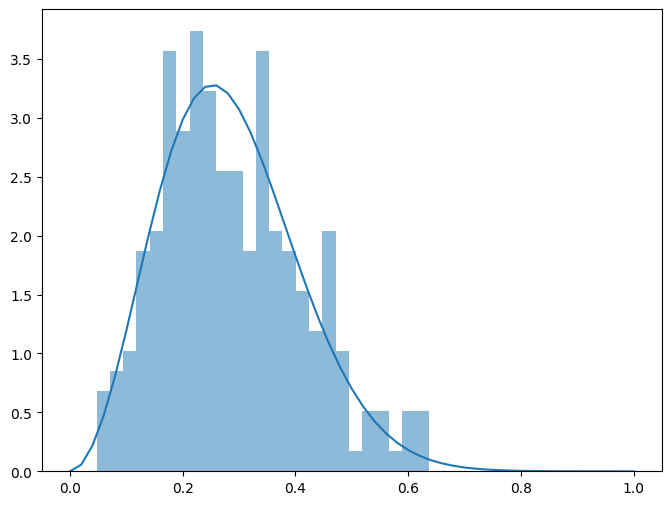

In [745]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds1, bins=25)

x2 = np.linspace(0, 1, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

E[t] = 0.289 ps
This corresponds to D_PMD = 0.048 ps/sqrt(km).
 


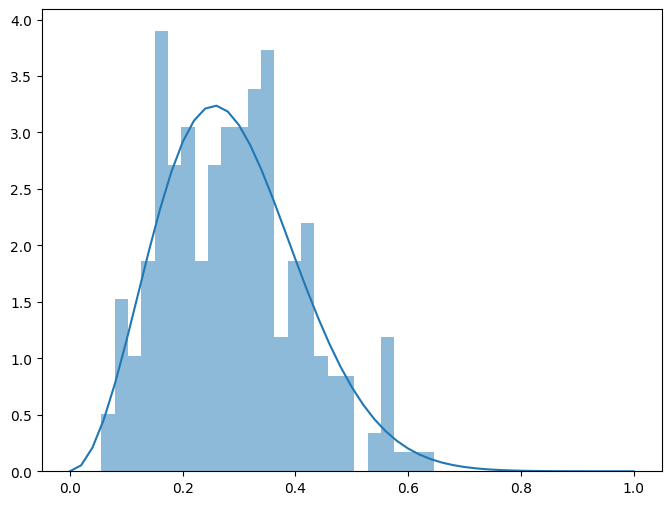

In [746]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds2, bins=25)

x2 = np.linspace(0, 1, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

[3.39628705e+01 3.53093139e-03 6.19139820e-02]


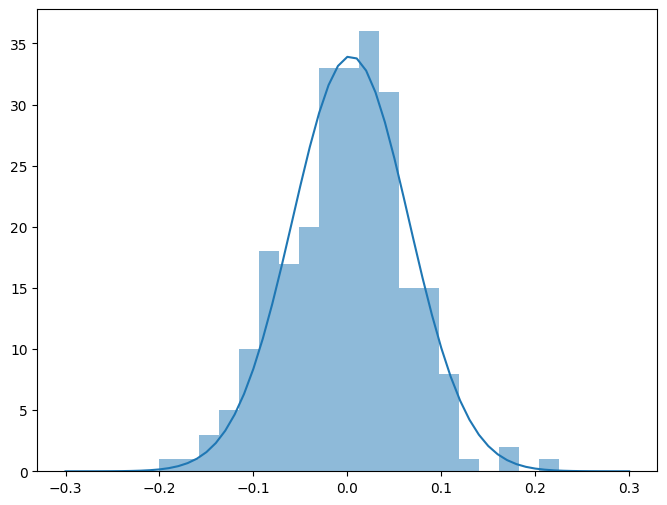

In [751]:
def MB(x, a, o, sigma): return a*np.exp(-((x-o)**2)/(2*(sigma**2)))

ns, bins = np.histogram(dgds2-dgds1, bins=20)

x2 = np.linspace(-0.3, 0.3, 61)
xs = (bins[1:] + bins[:-1])/2
ys = ns

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([50, 0, 0.1]))
print(popt)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, *popt))
plt.show()

That's pretty sensible actually! Cool!

Next let's try a 96-km aerial cable:

In [766]:
w0 = 1550e-9
T0 = 20
T1 = 25
L0 = 96e3
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
Tref = 20
rc = 0.15
tf = 0
tr = 0
m0 = 0.036
m1 = 0

Lr = 1500

N0 = 1

segmentDict = {'T0': T0, 'L0': L0, 'r0': r0, 'r1': r1, 'epsilon': epsilon, 'm0': m0, 'm1': m1, 'mProps': {}, 'Tref': Tref, 'rc': rc, 'tr': tr, 'tf': tf}
hingeDict = {'alpha': []}

nExp = 1000
dgds1 = np.zeros(nExp)
dgds2 = np.zeros(nExp)
t0 = time.time()
for i in range(nExp):
    f = Fiber(w0, segmentDict, hingeDict, N0, hingeType = 1, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    f.segmentDict['T0'] = T0
    dgds1[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    f.segmentDict['T0'] = T1
    dgds2[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
Completed in 1.34 minutes.


E[t] = 8.514 ps
This corresponds to D_PMD = 0.869 ps/sqrt(km).
 


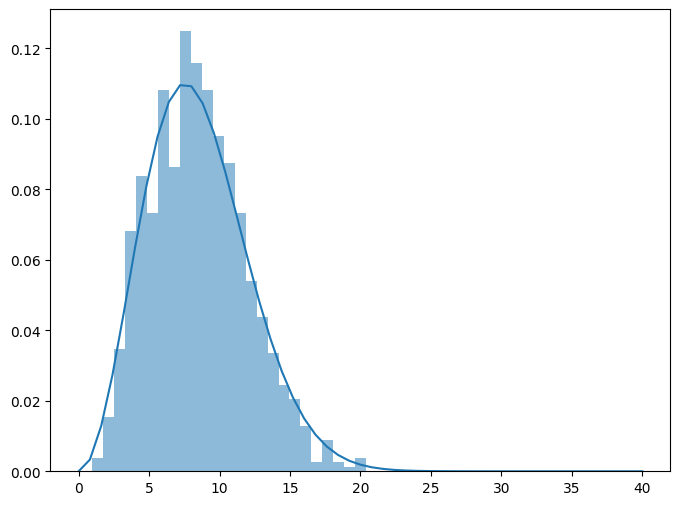

In [767]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds1, bins=25)

x2 = np.linspace(0, 40, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

E[t] = 8.556 ps
This corresponds to D_PMD = 0.873 ps/sqrt(km).
 


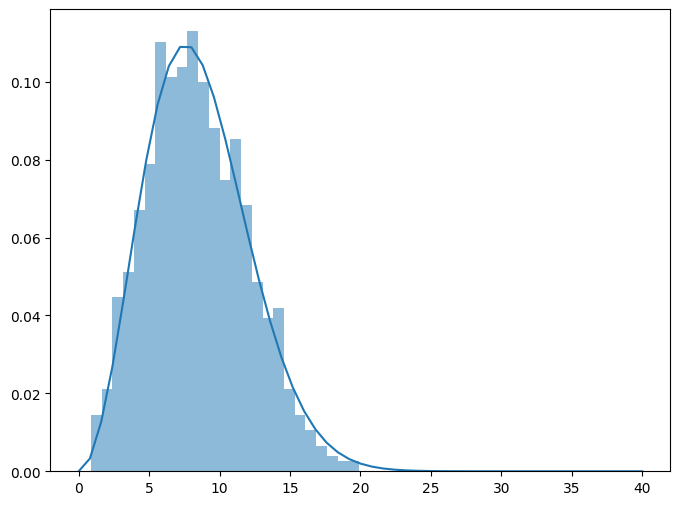

In [768]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds2, bins=25)

x2 = np.linspace(0, 40, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

[125.53214937  -0.13823018   4.67358507]


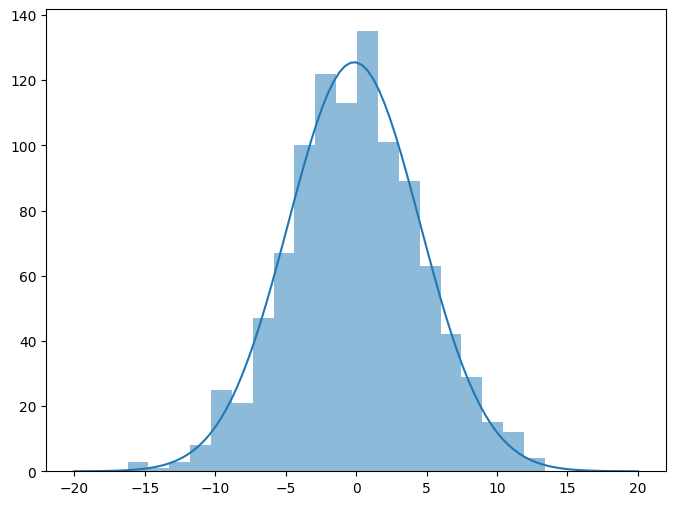

In [770]:
def MB(x, a, o, sigma): return a*np.exp(-((x-o)**2)/(2*(sigma**2)))

ns, bins = np.histogram(dgds2-dgds1, bins=20)

x2 = np.linspace(-20, 20, 101)
xs = (bins[1:] + bins[:-1])/2
ys = ns

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([150, 0, 5]))
print(popt)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, *popt))
plt.show()

This is totally matching up!

Last, let's try the 48.8-km fiber. It has two sections of 2 km length that are above ground and the rest are underground.

In [789]:
Ltot = 48.8e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 3

nPaddles = 3
rps = np.array([30, 30, 30])
#angles = np.array([2, 4, 2])*pi/180
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])
gapLs = np.array([100, 100, 100, 100])

Lr = 150

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0, 'L0': {'scale': 1000, 'dist': 'normal'}}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 30, 'scale': 3, 'dist': 'normal'},
             'gapLs': {'mean': 100, 'scale': 10, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

nExp = 1000
dgds1 = np.zeros(nExp)
dgds2 = np.zeros(nExp)
t0 = time.time()
for i in range(nExp):
    f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    f.hingeDict['T0'] = T0
    dgds1[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    f.hingeDict['T0'] = T1
    dgds2[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000  
Completed in 6.03 minutes.


E[t] = 1.963 ps
This corresponds to D_PMD = 0.200 ps/sqrt(km).
 


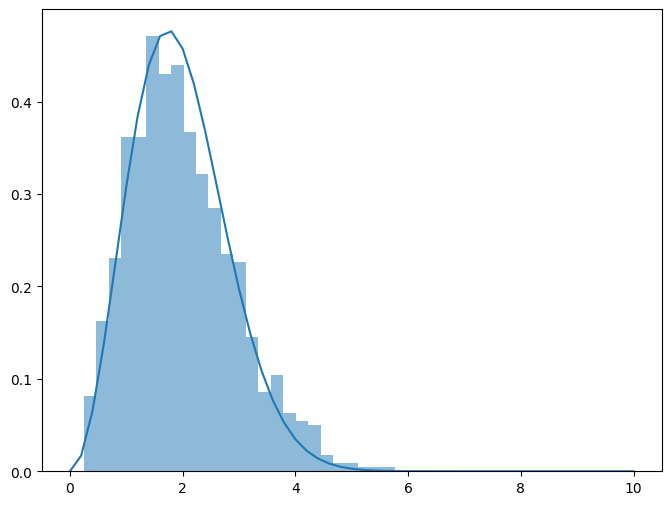

In [790]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds1, bins=25)

x2 = np.linspace(0, 10, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

E[t] = 1.974 ps
This corresponds to D_PMD = 0.201 ps/sqrt(km).
 


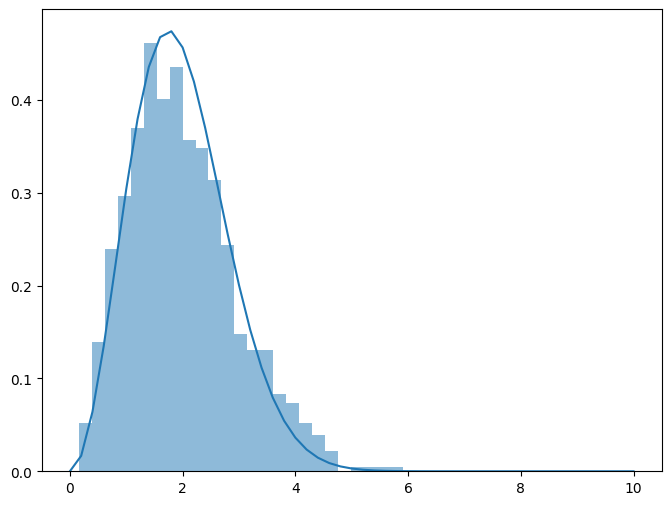

In [791]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds2, bins=25)

x2 = np.linspace(0, 10, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(L0/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

[ 2.01771437e+02 -1.29149148e-02  4.43486512e-01]


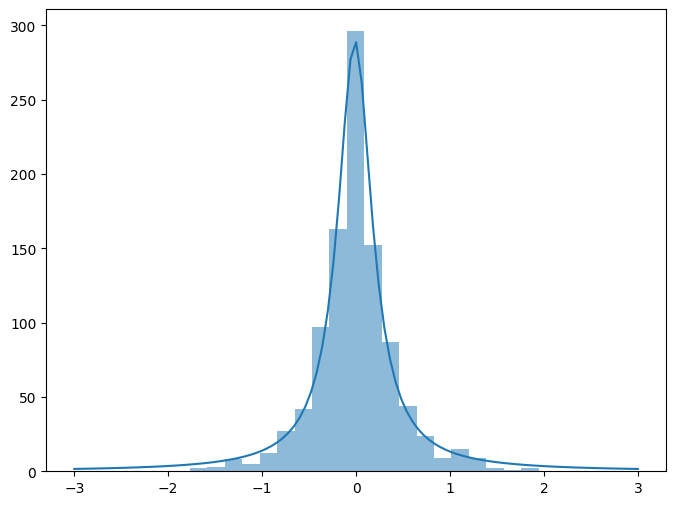

In [794]:
#def MB(x, a, o, sigma): return a*np.exp(-((x-o)**2)/(2*(sigma**2)))
def MB(x, a, o, sigma): return (a/pi)*(sigma/2)/((x-o)**2 + (sigma/2)**2)

ns, bins = np.histogram(dgds2-dgds1, bins=20)

x2 = np.linspace(-3, 3, 101)
xs = (bins[1:] + bins[:-1])/2
ys = ns

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([150, 0, 5]))
print(popt)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, *popt))
plt.show()

Note that sigma here (for the Lorentzian) is the *full* width half max, so changes are on the order of sigma/2.

That matches up super well!!! Wow!

### "Polarization-Mode Dispersion of Installed Recent Vintage Fiber as a Parametric Function of Temperature"
#### Misha Brodsky, Peter Magill, and Nicholas J. Frigo, *IEEE Photonics Technology Letters* 16(1), 2004

This paper is about correlations between DGD and temperature in a low-PMD fiber. Let's try it.

In [2]:
Ltot = 150e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 10

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 9

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

nExp = 250
dgds1 = np.zeros(nExp)
dgds2 = np.zeros(nExp)
t0 = time.time()
for i in range(nExp):
    f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})
    f.hingeDict['T0'] = T0
    dgds1[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    f.hingeDict['T0'] = T1
    dgds2[i] = f.calcDGD(dw0=0.0001e-9)*1e12
    if ((i+1) % 10 == 0):
        print(i+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250  
Completed in 108.07 minutes.


E[t] = 0.995 ps
This corresponds to D_PMD = 0.081 ps/sqrt(km).
 


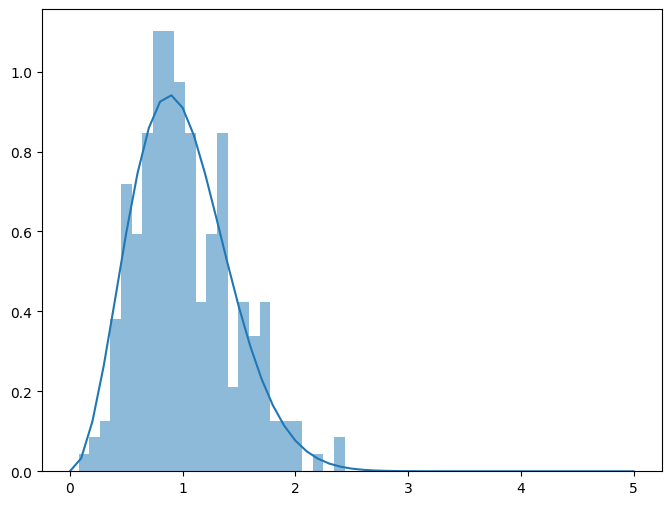

In [3]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds1, bins=25)

x2 = np.linspace(0, 5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

E[t] = 1.019 ps
This corresponds to D_PMD = 0.083 ps/sqrt(km).
 


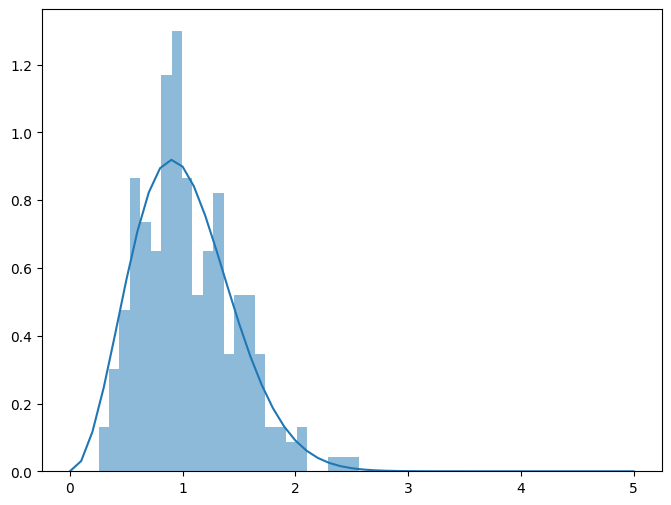

In [7]:
def MB(x, a): return (32/pi**2)*(x**2/a**3)*np.exp(-4*(x**2)/(pi*(a**2)))

ns, bins = np.histogram(dgds2, bins=25)

x2 = np.linspace(0, 5, 51)
xs = (bins[1:] + bins[:-1])/2
ys = ns/np.sum(ns * (bins[1]-bins[0]))

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([10]))
print("E[t] = {:.3f} ps".format(popt[0]))
print("This corresponds to D_PMD = {:.3f} ps/sqrt(km).".format(popt[0]/np.sqrt(Ltot/1e3)))
print(" ")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, popt[0]))
plt.show()

[-7.61920664  0.02989899 -0.23901338]


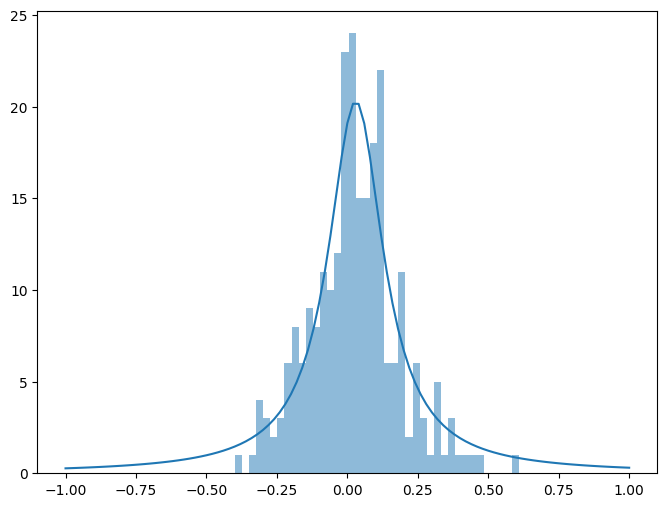

In [12]:
#def MB(x, a, o, sigma): return a*np.exp(-((x-o)**2)/(2*(sigma**2)))
def MB(x, a, o, sigma): return (a/pi)*(sigma/2)/((x-o)**2 + (sigma/2)**2)

ns, bins = np.histogram(dgds2-dgds1, bins=40)

x2 = np.linspace(-1, 1, 101)
xs = (bins[1:] + bins[:-1])/2
ys = ns

popt, pcov = opt.curve_fit(MB, xs, ys, p0=np.array([150, 0, 5]))
print(popt)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(xs, ys, width=(bins[1]-bins[0])*1.0, alpha=0.5)
ax.plot(x2, MB(x2, *popt))
plt.show()

Now let's simulate some random fibers and look at their DGD changes with wavelength:

In [25]:
Ltot = 150e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 10

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 9

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})

w0s = np.array([1529.5, 1533.5, 1556.5])*1e-9
T0s = np.linspace(6,16,21)

dgds = np.zeros((len(w0s), len(T0s)))
t0 = time.time()
for i in range(len(w0s)):
    f.w0 = w0s[i]
    print(i, end=": ")
    for j in range(len(T0s)):
        f.hingeDict['T0'] = T0s[j]
        dgds[i][j] = f.calcDGD(dw0=0.0001e-9)*1e12
        if ((j+1) % 10 == 0):
            print(j+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0: 10 20 1: 10 20 2: 10 20  
Completed in 13.75 minutes.


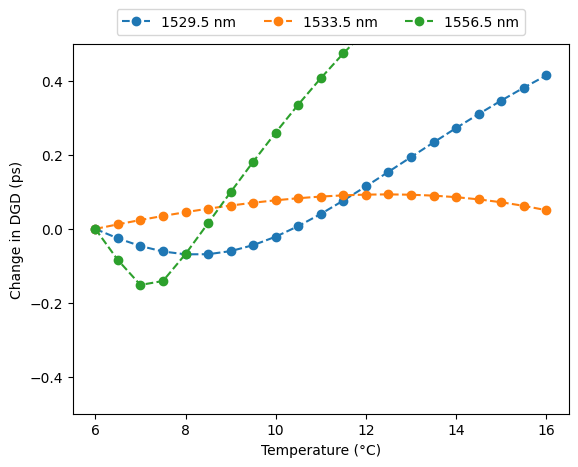

In [26]:
fig, ax = plt.subplots()
for i in range(len(w0s)):
    ax.plot(T0s, dgds[i] - dgds[i][0], label="{:.1f} nm".format(w0s[i]*1e9), ls='--', marker='o')
ax.set_ylim(-0.5,0.5)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Change in DGD (ps)")
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

In [30]:
Ltot = 150e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 10

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 9

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})

w0s = np.array([1529.5, 1533.5, 1556.5])*1e-9
T0s = np.linspace(6,16,21)

dgds = np.zeros((len(w0s), len(T0s)))
t0 = time.time()
for i in range(len(w0s)):
    f.w0 = w0s[i]
    print(i, end=": ")
    for j in range(len(T0s)):
        f.hingeDict['T0'] = T0s[j]
        dgds[i][j] = f.calcDGD(dw0=0.0001e-9)*1e12
        if ((j+1) % 10 == 0):
            print(j+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0: 10 20 1: 10 20 2: 10 20  
Completed in 13.78 minutes.


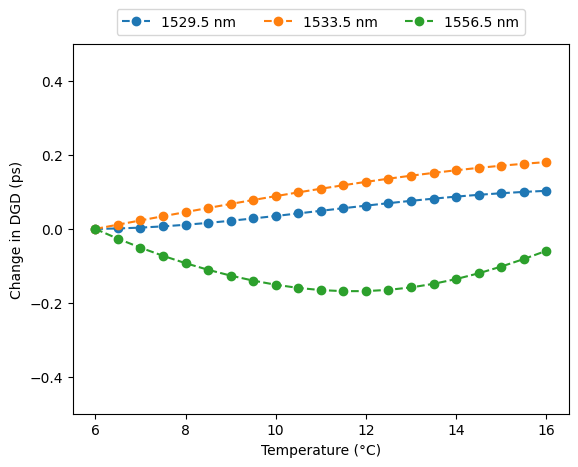

In [31]:
fig, ax = plt.subplots()
for i in range(len(w0s)):
    ax.plot(T0s, dgds[i] - dgds[i][0], label="{:.1f} nm".format(w0s[i]*1e9), ls='--', marker='o')
ax.set_ylim(-0.5,0.5)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Change in DGD (ps)")
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()

In [32]:
Ltot = 150e3

w0 = 1550e-9
T0 = 20
T1 = 25
r0 = 4.1e-6
r1 = 125e-6/2
epsilon = 1.005
m0 = 0.036
m1 = 0.000
Tref = 20

N0 = 10

nPaddles = 3
tfs = np.array([0, 0, 0])
Ns = np.array([2, 4, 2])

Lr = 9

segmentDict = {'m0': m0, 'm1': m1, 'T0': T0, 'Tref': Tref, 'rc': 0, 'tf': 0, 'tr': 0}
hingeDict = {'nPaddles': nPaddles, 'Ns': Ns, 'tfs': tfs,
             'rps': {'mean': 10, 'scale': 1, 'dist': 'normal'},
             'gapLs': {'mean': 5, 'scale': 0.5, 'dist': 'normal'},
             'angles': {'mean': 180, 'scale': 180, 'dist': 'uniform'}}

f = Fiber.random(w0, Ltot, N0, segmentDict, hingeDict, hingeType = 0, hingeStart = False, hingeEnd = False, arbRotStart = False, addRotators = {'mean': Lr, 'scale': Lr/10, 'dist': 'normal'})

w0s = np.array([1529.5, 1533.5, 1556.5])*1e-9
T0s = np.linspace(6,16,21)

dgds = np.zeros((len(w0s), len(T0s)))
t0 = time.time()
for i in range(len(w0s)):
    f.w0 = w0s[i]
    print(i, end=": ")
    for j in range(len(T0s)):
        f.hingeDict['T0'] = T0s[j]
        dgds[i][j] = f.calcDGD(dw0=0.0001e-9)*1e12
        if ((j+1) % 10 == 0):
            print(j+1, end= " ")
print(" ")
print("Completed in {:.2f} minutes.".format((time.time()-t0)/60))

0: 10 20 1: 10 20 2: 10 20  
Completed in 13.49 minutes.


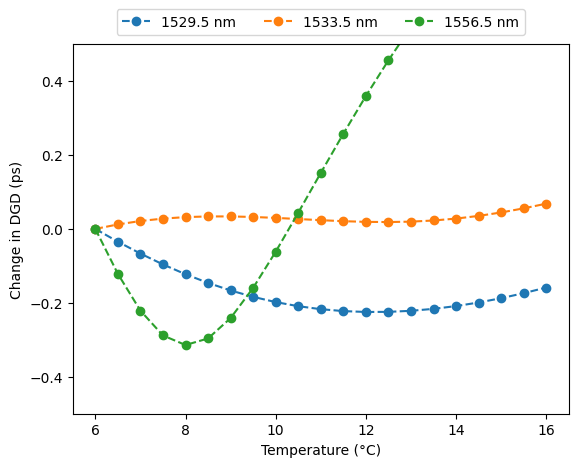

In [33]:
fig, ax = plt.subplots()
for i in range(len(w0s)):
    ax.plot(T0s, dgds[i] - dgds[i][0], label="{:.1f} nm".format(w0s[i]*1e9), ls='--', marker='o')
ax.set_ylim(-0.5,0.5)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Change in DGD (ps)")
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol = 5)
plt.show()